In [4]:
include("harvey.jl")
using .julia


using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions


using NLopt

using Plots
using StatsPlots  
using DataFrames
using XLSX

## Load data

In [8]:

file_path = "quarterly_gdp.xlsx"
sheet_name = "Quarterly GDP"

data = XLSX.readtable(file_path, sheet_name) |> DataFrame

println(data)

num_obs = size(data, 1)
println("Number of observations: ", num_obs)


134×2 DataFrame
 Row │ Date    Value 
     │ Any     Any   
─────┼───────────────
   1 │ 1991K1  364.6
   2 │ 1991K2  364.7
   3 │ 1991K3  368.6
   4 │ 1991K4  364.5
   5 │ 1992K1  371.5
   6 │ 1992K2  367.9
   7 │ 1992K3  377.2
   8 │ 1992K4  375.4
   9 │ 1993K1  371.8
  10 │ 1993K2  370
  11 │ 1993K3  373.2
  12 │ 1993K4  375.7
  13 │ 1994K1  385.1
  14 │ 1994K2  391.5
  15 │ 1994K3  393.3
  16 │ 1994K4  399.8
  17 │ 1995K1  404.2
  18 │ 1995K2  402.5
  19 │ 1995K3  404
  20 │ 1995K4  406.7
  21 │ 1996K1  407.8
  22 │ 1996K2  418.3
  23 │ 1996K3  419
  24 │ 1996K4  419.1
  25 │ 1997K1  424.8
  26 │ 1997K2  431.6
  27 │ 1997K3  429.7
  28 │ 1997K4  430.9
  29 │ 1998K1  437.5
  30 │ 1998K2  434
  31 │ 1998K3  441.2
  32 │ 1998K4  444.1
  33 │ 1999K1  447.8
  34 │ 1999K2  449.8
  35 │ 1999K3  451.7
  36 │ 1999K4  459.7
  37 │ 2000K1  462.9
  38 │ 2000K2  468.1
  39 │ 2000K3  468.9
  40 │ 2000K4  476.5
  41 │ 2001K1  469.1
  42 │ 2001K2  472.2
  43 │ 2001K3  475.3
  44 │ 2001K4  477.7
  

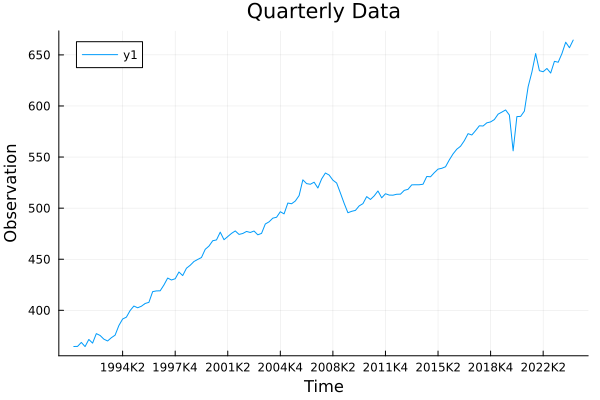

In [9]:
y = data[:, 2]
# y = log.(y)
dates = data[:, 1]

# Plot the data
plot(dates,y, title="Quarterly Data", xlabel="Time", ylabel="Observation")

In [10]:
#Define model
n_order = 2
state_dim = 2 + 2 * n_order
alpha_init = zeros(state_dim)
alpha_init[1] = y[1]
P1 = Matrix{Float64}(I(state_dim))*100  # Initial covariance matrix

#Priors
a_rho = 0.001
b_rho = 0.97
a_lambda = 0.001
b_lambda = π
a_xi = 1e-6
b_xi =1e-6
a_kappa = 1e-6
b_kappa = 1e-6
a_epsilon = 1e-6  
b_epsilon = 1e-6
priors = [a_rho, b_rho, a_lambda, b_lambda, a_xi, b_xi, a_kappa, b_kappa, a_epsilon, b_epsilon]




10-element Vector{Float64}:
 0.001
 0.97
 0.001
 3.141592653589793
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6
 1.0e-6

In [ ]:
# Run MCMC initialization
chain_init_burned, Sigma, acceptance_rate_init, chain_init = initialize_mcmc(
    y,
    priors,
    alpha_init, 
    P1, 
    n_order; 
    n_init=80000, 
    burn_init=40000, 
    omega_init=0.08)


Initialization Phase 100%|███████████████████████████████| Time: 0:00:36


Initialization Acceptance Rate: 32.6025 %


([1.131315028334461 -2.398254527302586 … 1.5942562259754114 2.932688740336189; 1.2609435610981847 -2.9199101156925082 … 1.7989448432417234 2.7924530335198314; … ; 1.109400540260739 -3.643022072158985 … 1.9751858555009147 2.889066932544836; 0.8941119755045149 -3.465548727669025 … 2.462073782392409 2.575859461119626], [0.2040666991914984 -0.054687561017672526 … -0.135380108501239 0.09726193045229943; -0.054687561017672526 1.5520342515112142 … -0.26534651712912316 0.012973148533864581; … ; -0.135380108501239 -0.26534651712912316 … 0.2941782354347245 -0.10926668376635079; 0.09726193045229943 0.012973148533864581 … -0.10926668376635079 0.1753852240561087], 0.326025, [0.7336429747217074 0.26262987991738107 … 4.924664871808083 18.77805198696183; 0.756033650495684 0.16172945628773774 … 6.043267504526506 16.3210067136655; … ; 0.7297047992853137 0.08110259572419565 … 7.2079591682003326 17.97652846013637; 0.6887361321905359 0.09618674942995313 … 11.729109958166736 13.142607866304392])

In [ ]:
parameters = ["rho", "lambda_c", "sigma_xi2", "sigma_kappa2", "sigma_epsilon2"]
n_params = length(parameters)


# Initialize a list to hold the plots
p_list = []

for i in 1:n_params
    param_samples_init = chain_init[:, i]
    
    
    # Traceplot of MCMC samples
    p2 = plot(param_samples_init, label="MCMC Samples", xlabel="Iteration", ylabel=parameters[i],
              title="Traceplot of $(parameters[i])")

    
    # Add plots to the list
    push!(p_list, p2)
end

# Display the plots
nrows = n_params
ncols = 2
plot(p_list..., layout=(nrows, ncols), size=(1200, 400 * n_params))


In [7]:
# Run MCMC recursion
theta_samples_burned, alpha_samples, acceptance_rate_rec = recursion_mcmc(
    y, 
    priors,
    alpha_init, 
    P1, 
    n_order, 
    chain_init_burned, 
    Sigma; 
    n_rec=40000, 
    burn_rec=20000, 
    omega_rec=0.25)


Recursion Phase 100%|████████████████████████████████████| Time: 0:00:42


Recursion Acceptance Rate: 38.055 %


([0.6459501490038281 0.0348976150174841 … 10.73805065896225 13.429011789343056; 0.6044211017888192 0.01775077499464926 … 12.007590117471388 15.095068196513946; … ; 0.7826171131916015 0.05599243425234127 … 6.839464394063391 18.581122682320814; 0.7826171131916015 0.05599243425234127 … 6.839464394063391 18.581122682320814], Any[[373.14712690600743 0.9655872433457873 … -6.353423875109943 -7.366317636646585; 374.1127141493531 0.8202914318961803 … -6.035787418855879 -4.514168658090519; … ; 648.373536784638 4.171840125233118 … 11.921260421480282 14.823169745285677; 652.5453769098708 4.389726355430938 … 5.487034443546998 14.358228573028976], [367.0966942055959 1.6876026280583636 … -0.30648298462524814 -1.3438943260269405; 368.7842968336542 1.926008175977696 … 0.7930626894978028 -0.10426941085927144; … ; 654.0235695701782 4.3230811173397194 … 3.7044065928915737 4.919674033871648; 658.3466506875179 3.842007110279629 … 1.1426173659951795 5.891301032977522], [365.93085022582505 2.573798755621999 …

In [8]:

# Initial guesses for parameters
initial_params = [0.5, 0.2, 0.5, 0.5, 0.5]

# Bounds for parameters
lower_bounds = [0.0, 0.0, 1e-6, 1e-6, 1e-6]
upper_bounds = [0.999, π, Inf, Inf, Inf]


# Define the objective function
function obj(params::Vector, grad::Vector)
    try
        return negative_log_likelihood(params, y, alpha_init, P1, n_order)
    catch e
        return 1e10  # Return a large number in case of error
    end
end

# Create the optimizer
opt = Opt(:LN_NELDERMEAD, length(initial_params))
opt.lower_bounds = lower_bounds
opt.upper_bounds = upper_bounds
opt.min_objective = obj
opt.maxeval = 1000
opt.xtol_rel = 1e-6

# Run the optimization
(minf, estimated_params, ret) = NLopt.optimize(opt, initial_params)

# Display the estimated parameters
println("Estimated Parameters: ", estimated_params)


Estimated Parameters: [0.0, 3.141592653589793, 8.037214609361751, 17.439982344566097, 1.0e-6]


In [9]:
parameters = ["rho", "lambda_c", "sigma_xi2", "sigma_kappa2", "sigma_epsilon2"]
n_params = length(parameters)




5

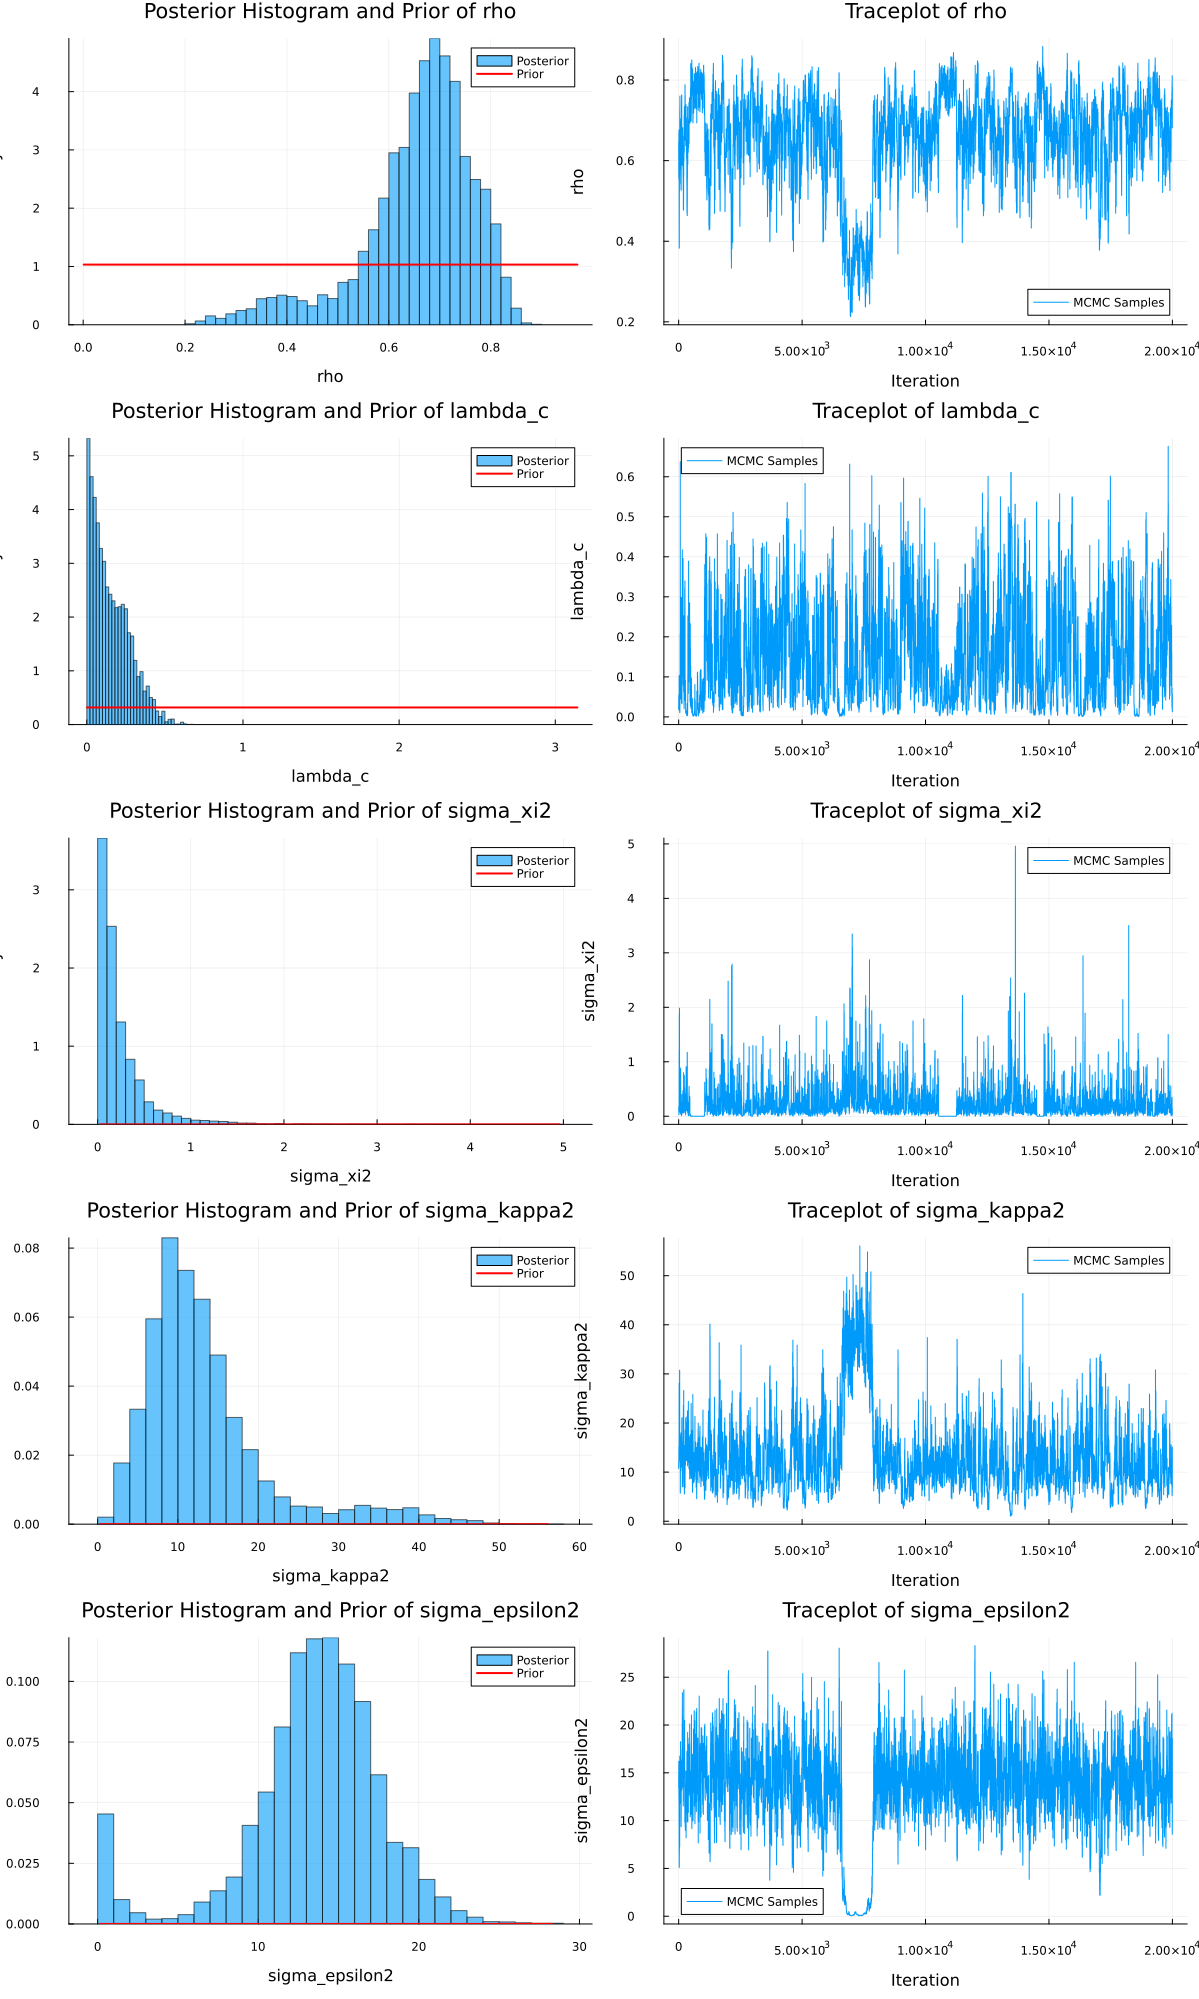

In [ ]:
# Initialize a list to hold the plots
p_list = []

for i in 1:n_params
    param_samples = theta_samples_burned[:, i]
    
    # Histogram of posterior samples
    p1 = histogram(param_samples, bins=50, normalize=true, alpha=0.6,
                   label="Posterior", xlabel=parameters[i], ylabel="Density",
                   title="Posterior Histogram and Prior of $(parameters[i])")
    
    # Define the prior distribution
    if parameters[i] == "rho"
        # Uniform prior between 0 and 0.999
        x_values = range(a_rho, b_rho, length=200)
        prior_pdf = pdf.(Uniform(a_rho, b_rho), x_values)
    elseif parameters[i] == "lambda_c"
        # beta distribution
        x_values = range(a_lambda, b_lambda, length=200)
        prior_pdf = pdf.(Uniform(a_lambda, b_lambda), x_values)
    elseif parameters[i] == "sigma_xi2"
        # Inverse Gamma prior
        x_values = range(0.0, maximum(param_samples), length=200)
        prior_pdf = pdf.(InverseGamma(a_xi, b_xi), x_values)
    elseif parameters[i] == "sigma_kappa2"
        # Inverse Gamma prior
        x_values = range(0.0, maximum(param_samples), length=200)
        prior_pdf = pdf.(InverseGamma(a_kappa, b_kappa), x_values)
    elseif parameters[i] == "sigma_epsilon2"
        # Inverse Gamma prior
        x_values = range(0.0, maximum(param_samples), length=200)
        prior_pdf = pdf.(InverseGamma(a_epsilon, b_epsilon), x_values)
    end
    
    # Overlay prior PDF on histogram
    plot!(p1, x_values, prior_pdf, label="Prior", color=:red, linewidth=2)
    
    # Traceplot of MCMC samples
    p2 = plot(param_samples, label="MCMC Samples", xlabel="Iteration", ylabel=parameters[i],
              title="Traceplot of $(parameters[i])")

    
    # Add plots to the list
    push!(p_list, p1)
    push!(p_list, p2)
end

# Display the plots 
nrows = n_params
ncols = 2
plot(p_list..., layout=(nrows, ncols), size=(1200, 400 * n_params))


In [11]:
# Calculate means of posterior samples
chain_rec_burned_means = mean(theta_samples_burned, dims=1)  # 1 x n_params array
chain_rec_burned_means = vec(chain_rec_burned_means)  # Convert to a vector


5-element Vector{Float64}:
  0.65677280949418
  0.15331621015421937
  0.23610253615836518
 13.284897067858582
 13.359141002025913

In [12]:

# Create the DataFrame
estimates_table = DataFrame(Dict(
    "Parameter" => parameters,
    "MCMC Estimate" => chain_rec_burned_means,
    # "MLE Estimate" => estimated_params,  # Include if available
    # "True Value" => params_true
))

# Display the DataFrame
display(estimates_table)


5×2 DataFrame
 Row │ MCMC Estimate  Parameter      
     │ Float64        String         
─────┼───────────────────────────────
   1 │      0.656773  rho
   2 │      0.153316  lambda_c
   3 │      0.236103  sigma_xi2
   4 │     13.2849    sigma_kappa2
   5 │     13.3591    sigma_epsilon2

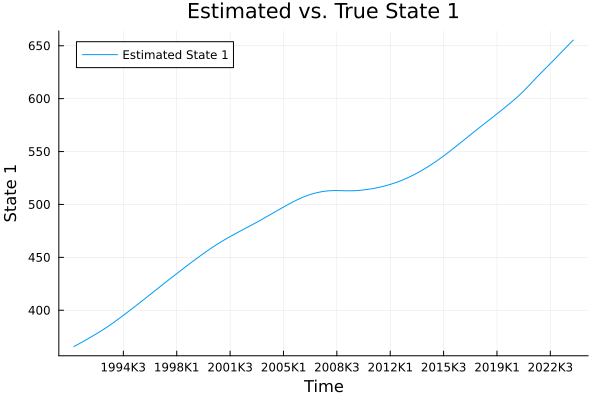

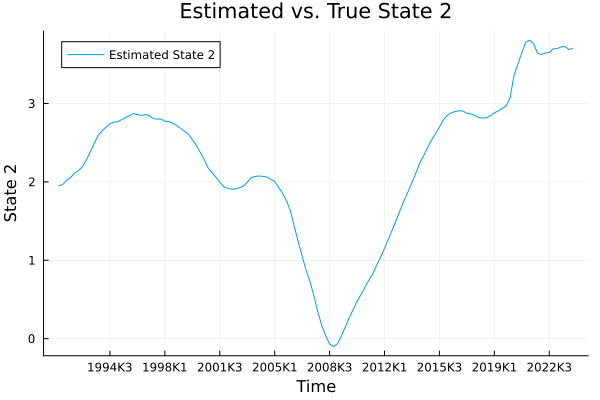

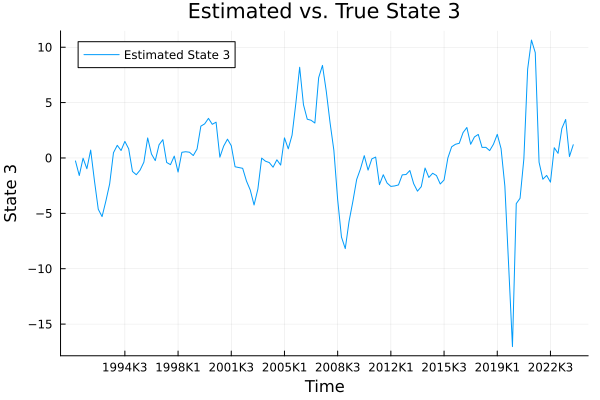

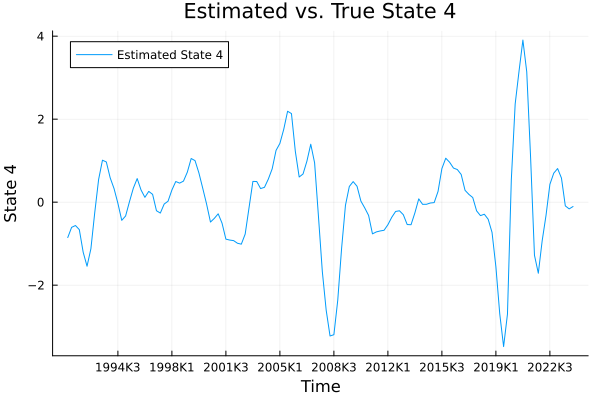

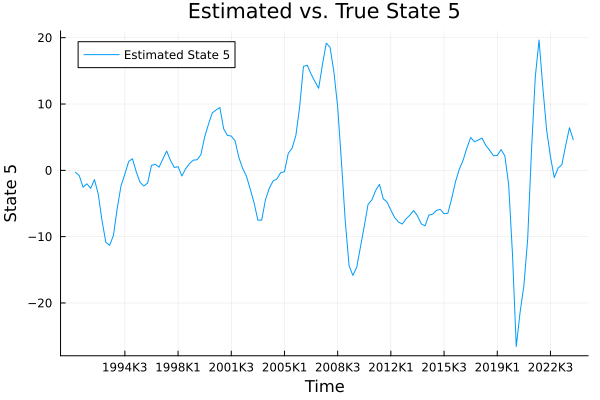

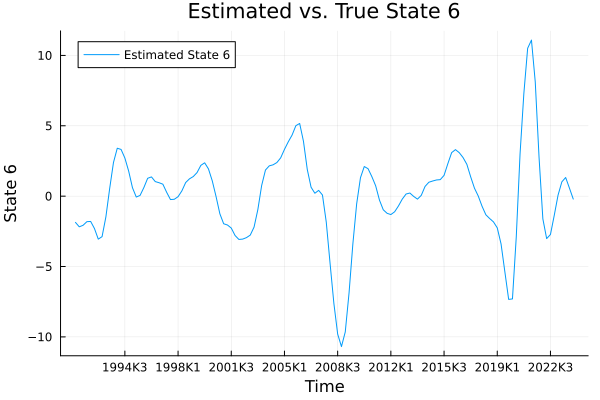

In [ ]:
# Collect alpha samples into a 3D array
n_samples = length(alpha_samples)
n_time_steps = size(alpha_samples[1], 1)
state_dim = size(alpha_samples[1], 2)

dates_plot = dates[2:end-1]


# Initialize array to hold alpha samples
alpha_samples_array = Array{Float64}(undef, n_samples, n_time_steps, state_dim)

for i in 1:n_samples
    alpha_samples_array[i, :, :] = alpha_samples[i]
end


# Compute posterior mean over samples (dimension 1)
alpha_mean = mean(alpha_samples_array, dims=1)  # 1 x n_time_steps x state_dim
alpha_mean = dropdims(alpha_mean; dims=1)  # n_time_steps x state_dim

# Compute credible intervals
alpha_lower = mapslices(x -> quantile(x, 0.025), alpha_samples_array; dims=1)
alpha_lower = dropdims(alpha_lower; dims=1)
alpha_upper = mapslices(x -> quantile(x, 0.975), alpha_samples_array; dims=1)
alpha_upper = dropdims(alpha_upper; dims=1)



time = 1:n_time_steps

for s in 1:state_dim
    p = plot(dates_plot, alpha_mean[:, s], label="Estimated State $(s)", xlabel="Time",
             ylabel="State $(s)", title="Estimated vs. True State $(s)")
    
    # Add credible intervals
    # plot!(dates_plot, alpha_mean[:, s], ribbon=(alpha_mean[:, s] .- alpha_lower[:, s],
    #       alpha_upper[:, s] .- alpha_mean[:, s]), fillalpha=0.3, label="95% Credible Interval")
  
    display(p)
end


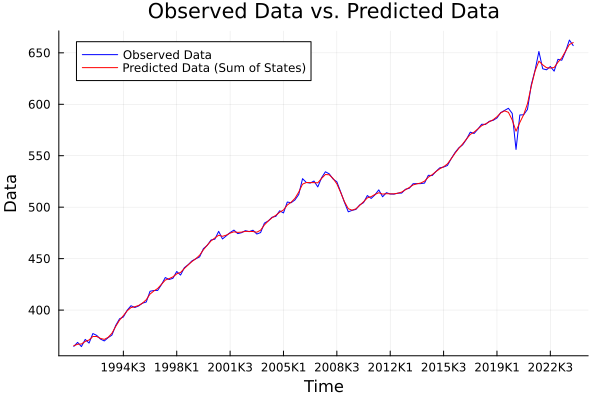

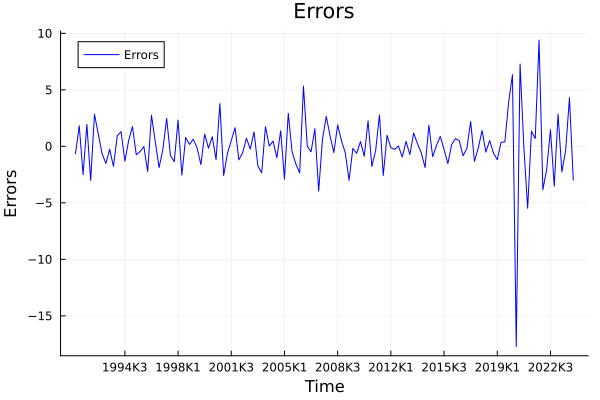

In [ ]:
# Compute y_pred

state_indices = [1, end-1]  

y_pred = alpha_mean[:, state_indices[1]] .+ alpha_mean[:, state_indices[2]]


# Adjust time and observed data if necessary
y_adjusted = y[2:end-1]  

p = plot(dates_plot, y_adjusted, label="Observed Data", color=:blue)
plot!(p, dates_plot, y_pred, label="Predicted Data (Sum of States)", color=:red)
xlabel!("Time")
ylabel!("Data")
title!("Observed Data vs. Predicted Data")
display(p)


errors = y_adjusted .- y_pred

p_error = plot(dates_plot, errors, label="Errors", color=:blue)
xlabel!("Time")
ylabel!("Errors")
title!("Errors")
display(p_error)


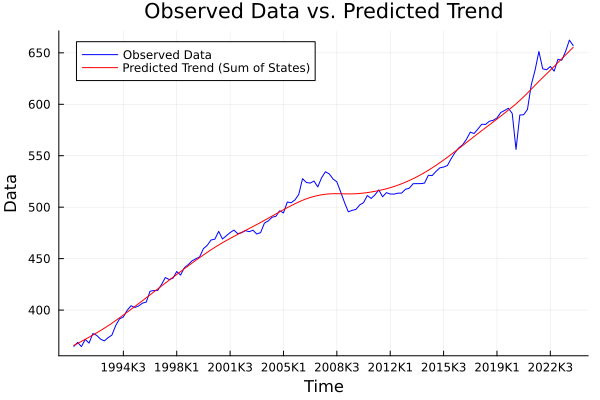

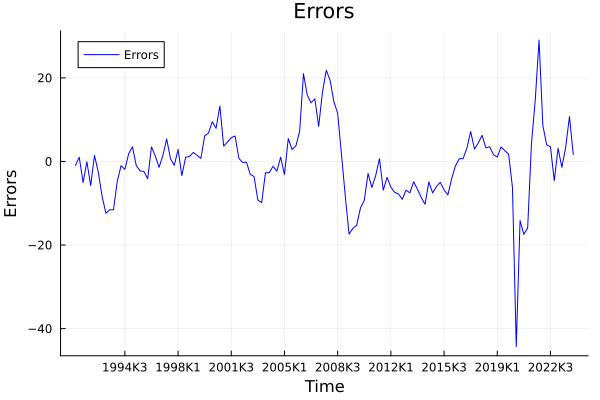

In [ ]:




state_indices = [1, end-1]  

y_pred = alpha_mean[:, state_indices[1]] 


# Adjust time and observed data if necessary
y_adjusted = y[2:end-1]

p = plot(dates_plot, y_adjusted, label="Observed Data", color=:blue)
plot!(p, dates_plot, y_pred, label="Predicted Trend", color=:red)
xlabel!("Time")
ylabel!("Data")
title!("Observed Data vs. Predicted Trend")
display(p)


errors = y_adjusted .- y_pred


p_error = plot(dates_plot, errors, label="Errors", color=:blue)
xlabel!("Time")
ylabel!("Errors")
title!("Errors")
display(p_error)
